#Implementing a simple POS-tagger

Part-of-speech tagging is a **classification** task where for each token a particular descriptor is assigned, called **tag**. 



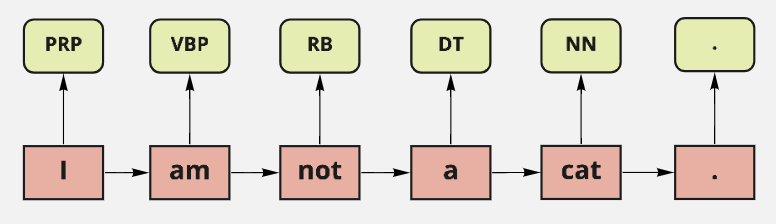

You're given a dataset witch consist of labeled data, dataset is split into `train` and `test` in **70/30** ratio.

***Format of the data is the following:***

```
Dataset = [Sentence]
Sentence = [Token with label]
Token with label = (Token, Label)
```

***For example:***

```python
train = [ 
  ...,
  [('I', 'PRP'), ('am', 'VBP'), ('not', 'RB'), ('a', 'DT'), ('cat', 'NN'), ('.', '.')],
  ...
 ]
```

In [1]:
# @title ☜ Download dataset
# Download and parse the dataset

import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from typing import List, Tuple
from typing_extensions import Protocol

TaggedSentence = List[Tuple[str, str]]

def download_dataset() -> Tuple[List[TaggedSentence], List[TaggedSentence]]:
  nltk.download('conll2000')
  nltk.download('universal_tagset')
  sentences = []
  current_sentence = []
  for word, tag in nltk.corpus.conll2000.tagged_words():
    current_sentence.append((word, tag))
    if tag == '.':
      sentences.append(current_sentence)
      current_sentence = []
  return train_test_split(sentences, test_size=0.3, random_state=42)

train, test = download_dataset()

[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [2]:
print(f"""Downloaded: 
        train: {len(train)} sentences
        test:  {len(test)} sentences
      """)

Downloaded: 
        train: 7561 sentences
        test:  3241 sentences
      


In [3]:
# @title ☜ Print tags

all_tags = sorted(list(set(tag for sentence in train for _, tag in sentence)))
columns = max(i for i in range(1, len(all_tags) // 2) if len(all_tags) % i == 0)
rows = len(all_tags) // columns
pd.DataFrame(dict((str(i), all_tags[i * rows:i * rows + rows]) for i in range(columns)))

,0,1,2,3,4,5,6,7,8,9,10
0,#,),CC,FW,JJS,NNPS,PRP,RBS,UH,VBN,WP
1,$,",",CD,IN,MD,NNS,PRP$,RP,VB,VBP,WP$
2,'',.,DT,JJ,NN,PDT,RB,SYM,VBD,VBZ,WRB
3,(,:,EX,JJR,NNP,POS,RBR,TO,VBG,WDT,``


#POS tagger's API

POS tagger should consist of just one function `pos_tag` which takes one argument - list of words (`strings`)

***For example:***

```
>>> tagger.pos_tag(["I", "am", "having", "fun", "."])

 [('I', 'PRP'), ('am', 'VBP'), ('having', 'VBG'), ('fun', 'NN'), ('.', '.')]
```

Please finish the implementation below ☟

In [19]:
words = []
labels = set()
for oneline in train:
  for token, tag in oneline:
    words.append(token)
    labels.add(tag)

len(words), len(labels)

(181099, 44)

In [21]:
import collections
vocab = collections.Counter(words)
assert len(vocab) == len(set(words))

In [49]:
min_freq = 2
list_tokens = [token for token, freq in vocab.most_common() if freq > min_freq]
list_tokens = ['UKN'] + list_tokens
print(list_tokens[:5])
token2idx = {token:idx for idx, token in enumerate(list_tokens)}

['UKN', ',', 'the', '.', 'of']


In [59]:
label2idx = {label:idx for idx, label in enumerate(list(labels))}

In [51]:
token2idx.get('UNK')

In [55]:
token2idx['UKN']

0

In [139]:
train_idx = []
label_idx = []
for oneline in train:
  one_train = [token2idx.get(token, 0) for token, tag in oneline]
  one_label = [label2idx.get(tag, 0) for token, tag in oneline]
  assert len(one_train) == len(one_label)
  train_idx.append(torch.from_numpy(np.array(one_train)))
  label_idx.append(torch.from_numpy(np.array(one_label)))

len(train_idx), len(label_idx)

(7561, 7561)

In [140]:
# train_idx[:5], label_idx[:5]

In [141]:
import numpy as np 
import torch
import torch.nn as nn 


In [162]:
class PosTagger(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
    super(PosTagger, self).__init__()
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim) # dropout = 0.2
    self.lin = nn.Linear(hidden_dim, tagset_size)
    self.hidden = self.zero_lstm_hidden()

  def zero_lstm_hidden(self):
    return (torch.zeros(1,1,self.hidden_dim), torch.zeros(1,1,self.hidden_dim))

  def forward(self, sentence):
    embed_out = self.embed(sentence)
    lstm_out, self.hidden = self.lstm(embed_out.view(len(sentence),1,-1) , self.hidden)
    lin_out = self.lin(lstm_out.view(len(sentence),-1))
    output = nn.functional.log_softmax(lin_out, dim =1)
    return output 

  def pos_tag(self, sentence):
    pass 


In [163]:

vocab_size = len(token2idx)
tagset_size = len(label2idx)
embedding_dim = int(vocab_size**0.5)
hidden_dim = 40
print(embedding_dim, hidden_dim, vocab_size, tagset_size)

model = PosTagger(embedding_dim, hidden_dim, vocab_size, tagset_size)
model


78 40 6162 44


PosTagger(
  (embed): Embedding(6162, 78)
  (lstm): LSTM(78, 40)
  (lin): Linear(in_features=40, out_features=44, bias=True)
)

In [164]:
# CLASS torch.optim.AdamW(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False, *, maximize=False)

import torch.optim as optim 
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
loss_func = torch.nn.NLLLoss()

In [165]:
# train_idx, label_idx

In [166]:
len(train_idx), len(label_idx)

(7561, 7561)

In [167]:
num_epoch = 10
for epoch in range(1, num_epoch + 1):
  epoch_loss = 0
  for sent, label in zip(train_idx, label_idx):
    model.zero_lstm_hidden()
    model.zero_grad()
    pred = model(sent)
    loss = loss_func(pred, label)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
  print(f'epoch : {epoch}, \t loss: {epoch_loss}')

RuntimeError: ignored

In [161]:
# POS tagger interface, please change anything except the interface
class PosTagger:

  def pos_tag(self, sentence: List[str]) -> TaggedSentence:
    return [(word, "NN") for word in sentence]



#Evaluation

For evaluation we use two metrics:
 
1.   **Token accuracy** - percent of correctly predicted labels 
2.   **Sentence accuracy** - percent of sentences where all labels were correct

In [5]:
# @title ☜ def evaluate(...)
# Model evaluation code

def evaluate(pos_tagger, dataset: List[TaggedSentence]):
  """Run a model with a given dataset and return the evaluation metrics.

  @param pos_tagger: A POS tagger implementation
  @param dataset: A dataset to use for evaluation
  @return: Number of correctly predicted tokens, total number of tokens, token
    accuracy, sentence accuracy.
  """
  correct_tokens, correct_sentences, total = 0, 0, 0

  for expected in dataset:
    actual = pos_tagger.pos_tag([w for w, _ in expected])

    correct_sentence = True

    if len(actual) != len(expected):
      raise Exception(f"Size mismatch: {len(actual)} != {len(expected)}")

    for (_, guess), (_, golden) in zip(actual, expected):
      if guess == golden:
        correct_tokens += 1
      else:
        correct_sentence = False
      total += 1

    if correct_sentence:
      correct_sentences += 1
  
  return pd.DataFrame({
          "Total": [total], 
          "Correct": [correct_tokens],
          "Token Accuracy": [correct_tokens / total,], 
          "Sentence Accuracy": [correct_sentences / len(dataset)]})

In [6]:
# Evaluate the naive implementation

evaluate(PosTagger(), test)

,Total,Correct,Token Accuracy,Sentence Accuracy
0,78005,11089,0.142158,0.0


#NLTK Baseline

NLTK implementation is using a simple perceptron

In [7]:
# Create and evaluate an existing implementation from NLTK

nltk.download('averaged_perceptron_tagger')

# run evaluation
evaluate(nltk, test)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,Total,Correct,Token Accuracy,Sentence Accuracy
0,78005,74700,0.957631,0.422092


In [8]:
#@title 
import gensim.downloader as api
import numpy as np

model_gigaword = api.load("glove-wiki-gigaword-50")

def to_embeddings(word):
  if word in model_gigaword:
    return model_gigaword[word]
  return np.zeros(model_gigaword.vector_size)

[==================================================] 100.0% 66.0/66.0MB downloaded
